# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path
from itertools import product

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename, load_parquet_subset
from lib.aggregate.cell_data_utils import split_cell_data, channel_combo_subset
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.aggregate.filter import (
    query_filter,
    perturbation_filter,
    missing_values_filter,
    intensity_filter,
)
from lib.aggregate.align import (
    prepare_alignment_data,
    pca_variance_plot,
    embed_by_pca,
    tvn_on_controls,
)
from lib.aggregate.aggregate import aggregate
from lib.aggregate.eval_aggregate import (
    nas_summary,
    plot_feature_distributions,
    summarize_cell_data,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

## <font color='red'>SET PARAMETERS</font>

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL`: Well identifier used for testing configuration

In [3]:
TEST_PLATE = 1
TEST_WELL = "A1"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=50000)
display(cell_data)

Reading first 50,000 rows from /lab/cheeseman_ops/brieflow-screens/denali-analysis/analysis/analysis_root/merge/parquets/P-1_W-A1__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1045,437,1478.403947,1481.714474,243,265,100.607843,670.117647,...,0,0.000000,48.564099,54.586397,164.116340,0,0.000000,48.615252,55.257173,159.483845
1,1,A1,401,494,1477.766431,1478.877654,101,302,100.089552,669.910448,...,1,0.065657,45.153871,62.255752,106.221846,1,0.037791,40.275758,56.068075,115.752777
2,1,A1,1502,507,1480.628283,1477.384343,354,280,100.674419,99.806202,...,0,0.000000,50.811479,74.397288,151.581091,0,0.000000,52.963143,70.225474,167.657553
3,1,A1,595,482,1480.676399,1482.874696,154,228,100.764706,670.764706,...,2,0.229299,37.000701,51.898329,172.518929,2,0.068627,38.735022,47.030219,157.402576
4,1,A1,1479,613,1477.695030,1481.850904,365,352,99.764045,671.494382,...,0,0.000000,57.800029,61.225938,139.073759,0,0.000000,62.404446,63.974515,134.672172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A1,1569,653,1728.326458,1597.428876,369,2317,732.563218,131.034483,...,0,0.000000,45.356211,58.364715,109.133333,0,0.000000,46.235990,58.631440,164.461494
49996,1,A1,941,492,1684.513544,1663.389391,233,303,150.982143,716.116071,...,0,0.000000,81.068643,88.727647,76.725794,0,0.000000,72.599442,80.938046,83.413197
49997,1,A1,911,494,1207.529769,1445.108141,220,1858,601.915254,91.203390,...,0,0.000000,45.038072,63.114432,65.686930,0,0.000000,45.787703,72.450334,59.700141
49998,1,A1,391,559,1410.022422,1745.634978,96,277,81.890411,736.397260,...,0,0.000000,52.224732,71.559702,167.369728,0,0.000000,52.909050,71.546328,169.621047


In [5]:
for col in cell_data.columns:
    print(col)

plate
well
tile
cell_0
i_0
j_0
site
cell_1
i_1
j_1
distance
fov_distance_0
fov_distance_1
sgRNA_0
gene_symbol_0
mapped_single_gene
channels_min
nucleus_DAPI_int
nucleus_COXIV_int
nucleus_CENPA_int
nucleus_WGA_int
nucleus_DAPI_mean
nucleus_COXIV_mean
nucleus_CENPA_mean
nucleus_WGA_mean
nucleus_DAPI_std
nucleus_COXIV_std
nucleus_CENPA_std
nucleus_WGA_std
nucleus_DAPI_max
nucleus_COXIV_max
nucleus_CENPA_max
nucleus_WGA_max
nucleus_DAPI_min
nucleus_COXIV_min
nucleus_CENPA_min
nucleus_WGA_min
nucleus_DAPI_int_edge
nucleus_COXIV_int_edge
nucleus_CENPA_int_edge
nucleus_WGA_int_edge
nucleus_DAPI_mean_edge
nucleus_COXIV_mean_edge
nucleus_CENPA_mean_edge
nucleus_WGA_mean_edge
nucleus_DAPI_std_edge
nucleus_COXIV_std_edge
nucleus_CENPA_std_edge
nucleus_WGA_std_edge
nucleus_DAPI_max_edge
nucleus_COXIV_max_edge
nucleus_CENPA_max_edge
nucleus_WGA_max_edge
nucleus_DAPI_min_edge
nucleus_COXIV_min_edge
nucleus_CENPA_min_edge
nucleus_WGA_min_edge
nucleus_DAPI_mass_displacement
nucleus_COXIV_mass_displace

## <font color='red'>SET PARAMETERS</font>

### Cell Data Metadata

- `METADATA_COLS_FP`: Path to TSV to store metadata cols.
- `METADATA_COLS`: Columns in cell data with metadata (use output above).

In [6]:
METADATA_COLS_FP = "config/cell_data_metadata_cols.tsv"
METADATA_COLS = [
    "plate",
    "well",
    "tile",
    "cell_0",
    "i_0",
    "j_0",
    "site",
    "cell_1",
    "i_1",
    "j_1",
    "distance",
    "fov_distance_0",
    "fov_distance_1",
    "sgRNA_0",
    "gene_symbol_0",
    "mapped_single_gene",
    "channels_min",
    "nucleus_i",
    "nucleus_j",
    "nucleus_bounds_0",
    "nucleus_bounds_1",
    "nucleus_bounds_2",
    "nucleus_bounds_3",
    "cell_i",
    "cell_j",
    "cell_bounds_0",
    "cell_bounds_1",
    "cell_bounds_2",
    "cell_bounds_3",
    "cytoplasm_i",
    "cytoplasm_j",
    "cytoplasm_bounds_0",
    "cytoplasm_bounds_1",
    "cytoplasm_bounds_2",
    "cytoplasm_bounds_3",
]

In [7]:
pd.Series(METADATA_COLS).to_csv(METADATA_COLS_FP, index=False, header=False, sep="\t")

metadata, features = split_cell_data(cell_data, METADATA_COLS)
print(metadata.shape, features.shape)

Split data: 35 metadata columns, 1649 feature columns
(50000, 35) (50000, 1649)


## <font color='red'>SET PARAMETERS</font>

### Split cells into classes

- `CLASSIFIER_PATH`: Path to pickled Python object that can take a cell data dataframe and output cell classes

### Evaluate splitting

- `COLLAPSE_COLS`: Columns to collapse on when creating a summary of cell counts.
- `MONTAGE_CHANNEL`: Channel to use for montage generation. Usually `DAPI`

**Note**: You must import necessary packages for the classifier here and add them to `scripts/aggregate/split_datasets.py` as well.

In [8]:
CLASSIFIER_PATH = "config/binary_xgb_robust_model.dill"
MONTAGE_CHANNEL = "DAPI"
COLLAPSE_COLS = ["sgRNA_0", "gene_symbol_0"]

import numpy as np

Removing 1516 rows with NaN values in features
Cell class counts:
class
interphase    47845
mitotic         639
Name: count, dtype: int64

Cell class confidences:


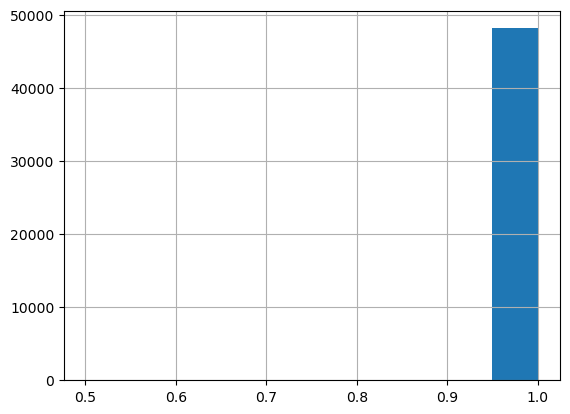

In [9]:
classifier = CellClassifier.load(CLASSIFIER_PATH)
metadata, features = classifier.classify_cells(metadata, features)

# Create config var for cell classes
CELL_CLASSES = list(metadata["class"].unique())

# Show cell class counts and distribution
print("Cell class counts:")
print(metadata["class"].value_counts())

print("\nCell class confidences:")
metadata["confidence"].hist()
plt.show()

Montages of cell classes:


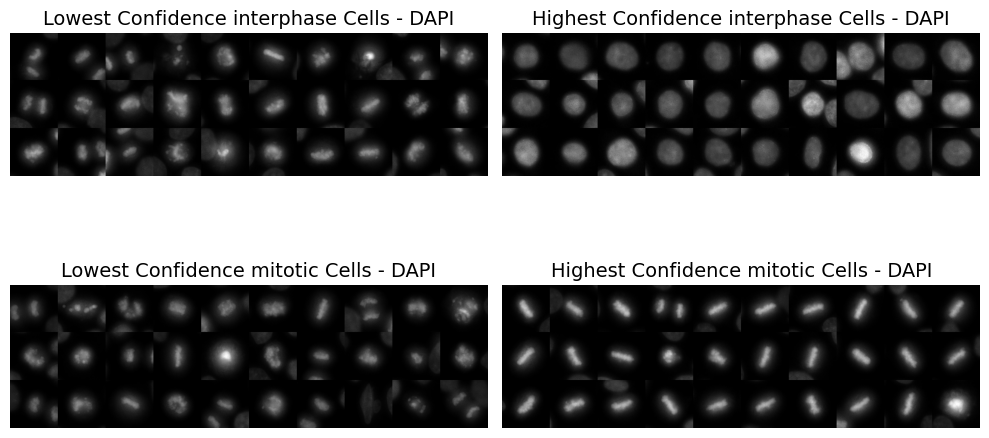

Split cell data summary:


,Stage,Count
0,Raw Data,48484
1,interphase cells,47845
2,interphase sgRNA_0,9422
3,interphase gene_symbol_0,4565
4,mitotic cells,639
5,mitotic sgRNA_0,170
6,mitotic gene_symbol_0,169


In [10]:
classified_metadata = metadata.copy()
classified_metadata = add_filenames(classified_metadata, ROOT_FP)

# Create a dictionary of DataFrames for each cell class
cell_class_dfs = {
    cell_class: classified_metadata[classified_metadata["class"] == cell_class]
    for cell_class in CELL_CLASSES
}

# Define sorting directions and titles
title_templates = {
    True: "Lowest Confidence {cell_class} Cells - {channel}",
    False: "Highest Confidence {cell_class} Cells - {channel}",
}

# Generate montages dynamically
montages, titles = [], []
for cell_class, cell_df in cell_class_dfs.items():
    for ascending in [True, False]:
        montage = create_cell_montage(
            cell_data=cell_df,
            channels=config["phenotype"]["channel_names"],
            selection_params={
                "method": "sorted",
                "sort_by": "confidence",
                "ascending": ascending,
            },
        )[MONTAGE_CHANNEL]
        montages.append(montage)
        titles.append(
            title_templates[ascending].format(
                cell_class=cell_class, channel=MONTAGE_CHANNEL
            )
        )

# Determine figure size dynamically
num_rows = len(CELL_CLASSES)
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))

# Display montages
for ax, title, montage in zip(axes.flat, titles, montages):
    ax.imshow(montage, cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

print("Montages of cell classes:")
plt.tight_layout()
plt.show()

print("Split cell data summary:")
summary_df = summarize_cell_data(metadata, CELL_CLASSES, COLLAPSE_COLS)
summary_df

## <font color='red'>SET PARAMETERS</font>

### Aggregate by channel combos

- `CHANNEL_COMBOS`: Combinations of channels to aggregate by.
- `AGGREGATE_COMBO_DF_FP`: Location of aggregate combinations dataframe.
- `TEST_CHANNEL_COMBO`: Channel combo to configure aggregate params with.

In [11]:
CHANNEL_COMBOS = [
    ["DAPI", "COXIV", "CENPA", "WGA"],
    ["DAPI", "CENPA"],
    ["DAPI", "WGA"],
]
AGGREGATE_COMBO_DF_FP = "config/aggregate_combo.tsv"
TEST_CHANNEL_COMBO = ["DAPI", "CENPA"]

In [12]:
# determine cell classes and channel combos
cell_classes = list(metadata["class"].unique()) + ["all"]
channel_combos = ["_".join(combo) for combo in CHANNEL_COMBOS]

# Gemerate aggregate wildcard combos
MERGE_COMBO_FP = Path(config["merge"]["merge_combo_fp"])
merge_wildcard_combos = pd.read_csv(MERGE_COMBO_FP, sep="\t")

# Generate full combinations
aggregate_wildcard_combos = pd.DataFrame(
    product(
        merge_wildcard_combos.itertuples(index=False, name=None),
        cell_classes,
        channel_combos,
    ),
    columns=["plate_well", "cell_class", "channel_combo"],
)
aggregate_wildcard_combos[["plate", "well"]] = pd.DataFrame(aggregate_wildcard_combos["plate_well"].tolist(), index=aggregate_wildcard_combos.index)
aggregate_wildcard_combos = aggregate_wildcard_combos.drop(columns="plate_well")

# Save aggregate wildcard combos
aggregate_wildcard_combos.to_csv(AGGREGATE_COMBO_DF_FP, sep="\t", index=False)

print("Aggregate wildcard combos:")
aggregate_wildcard_combos

Aggregate wildcard combos:


,cell_class,channel_combo,plate,well
0,interphase,DAPI_COXIV_CENPA_WGA,1,A2
1,interphase,DAPI_CENPA,1,A2
2,interphase,DAPI_WGA,1,A2
3,mitotic,DAPI_COXIV_CENPA_WGA,1,A2
4,mitotic,DAPI_CENPA,1,A2
...,...,...,...,...
157,mitotic,DAPI_CENPA,1,A3
158,mitotic,DAPI_WGA,1,A3
159,all,DAPI_COXIV_CENPA_WGA,1,A3
160,all,DAPI_CENPA,1,A3


In [13]:
all_channels = config["phenotype"]["channel_names"]
features = channel_combo_subset(features, TEST_CHANNEL_COMBO, all_channels)
features

,nucleus_DAPI_int,nucleus_CENPA_int,nucleus_DAPI_mean,nucleus_CENPA_mean,nucleus_DAPI_std,nucleus_CENPA_std,nucleus_DAPI_max,nucleus_CENPA_max,nucleus_DAPI_min,nucleus_CENPA_min,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,4094709,598918,2693.887500,394.025000,442.450180,86.229403,3743,736,1543,205,...,0,0.000000,48.564099,54.586397,164.116340,0,0.000000,48.615252,55.257173,159.483845
1,3451583,481848,3489.972700,487.207280,677.083422,83.525917,5097,837,1518,299,...,1,0.065657,45.153871,62.255752,106.221846,1,0.037791,40.275758,56.068075,115.752777
2,8374966,772320,4229.780808,390.060606,705.971034,84.012141,6351,885,2079,216,...,0,0.000000,50.811479,74.397288,151.581091,0,0.000000,52.963143,70.225474,167.657553
3,3963469,412576,4821.738443,501.917275,1145.039846,96.595718,6935,798,2121,274,...,2,0.229299,37.000701,51.898329,172.518929,2,0.068627,38.735022,47.030219,157.402576
4,3901274,434712,2937.706325,327.343373,512.928871,81.272696,4710,670,1562,182,...,0,0.000000,57.800029,61.225938,139.073759,0,0.000000,62.404446,63.974515,134.672172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4123142,451976,2932.533428,321.462304,594.082744,80.179925,4707,591,1327,162,...,0,0.000000,45.356211,58.364715,109.133333,0,0.000000,46.235990,58.631440,164.461494
49996,5796330,607773,3271.066591,342.987020,572.313631,99.344496,4769,862,1496,178,...,0,0.000000,81.068643,88.727647,76.725794,0,0.000000,72.599442,80.938046,83.413197
49997,3644416,370535,4428.208991,450.224787,1025.091769,70.534166,6121,675,2132,284,...,0,0.000000,45.038072,63.114432,65.686930,0,0.000000,45.787703,72.450334,59.700141
49998,4000538,479665,3587.926457,430.192825,858.667423,72.225081,5385,723,1790,259,...,0,0.000000,52.224732,71.559702,167.369728,0,0.000000,52.909050,71.546328,169.621047


## <font color='red'>SET PARAMETERS</font>

### Perturbation filtering

- `FILTER_QUERIES`: Queries to use for custom filtering; ex: `["mapped_single_gene == False", "cell_quality_score > 0.8"]`. Can be left as `None` for no filtering.
- `PERTURBATION_NAME_COL`: Name of column used to identify perturbation

In [14]:
FILTER_QUERIES = None
PERTURBATION_NAME_COL = "gene_symbol_0"

Found 22122 cells with assigned perturbations
Unique populations: 4574


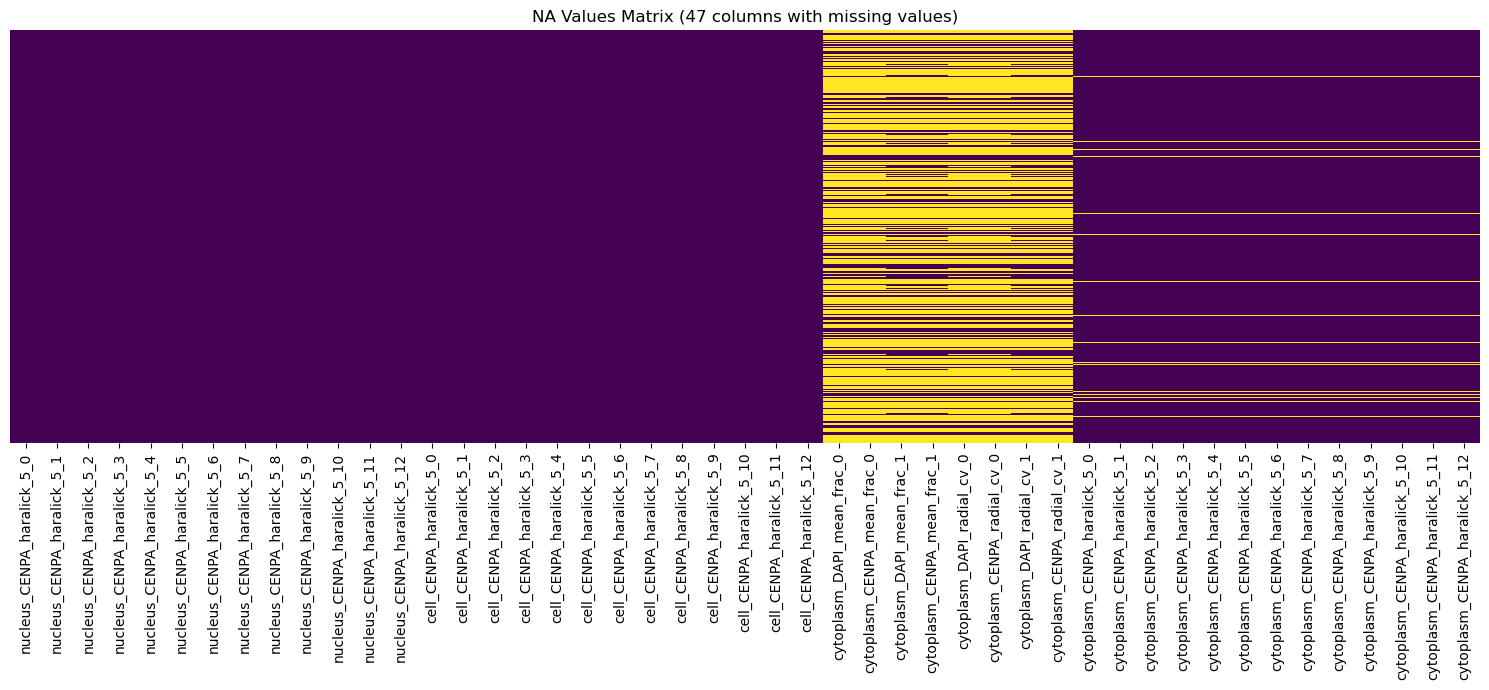

In [15]:
metadata, features = query_filter(metadata, features, FILTER_QUERIES)

metadata, features = perturbation_filter(
    metadata, features, PERTURBATION_NAME_COL
)
print(f"Unique populations: {metadata[PERTURBATION_NAME_COL].nunique()}")

sumamry_df, fig = nas_summary(features)
sumamry_df[sumamry_df["percent_na"] > 0.1]
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Missing value filtering

- `DROP_COLS_THRESHOLD`: Threshold of NA values above which an entire column is dropped. Usually `0.1`
- `DROP_ROWS_THRESHOLD`: Threshold of NA values above which an entire row is dropped. Usually `0.01`
- `IMPUTE`: Whether or not to impute remaining missing values. Usually `True`

**Note**: All NAs must be dropped or imputed to perform feature alignment.

In [16]:
DROP_COLS_THRESHOLD = 0.1
DROP_ROWS_THRESHOLD = 0.01
IMPUTE = True

In [17]:
# Filter by missing values
metadata, features = missing_values_filter(
    metadata,
    features,
    drop_cols_threshold=DROP_COLS_THRESHOLD,
    drop_rows_threshold=DROP_ROWS_THRESHOLD,
    impute=True,
)

metadata.shape, features.shape

Dropping 8 columns with ≥10.0% missing values
Dropped 877 rows with ≥1.0% missing values


((21245, 37), (21245, 861))

## <font color='red'>SET PARAMETERS</font>

### Intensity filtering

- `CONTAMINATION`: Expected proportion of outliers in dataset. Usually `0.01`

In [18]:
CONTAMINATION = 0.01

In [19]:
# Filter by intensity outliers
metadata, features = intensity_filter(
    metadata,
    features,
    config["phenotype"]["channel_names"],
    CONTAMINATION,
)

metadata.shape, features.shape

((21032, 37), (21032, 861))

## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `BATCH_COLS`: Which columns of metadata have batch-specific information. Usually `["plate", "well"]`.
- `CONTROL_KEY`: Name of perturbation in `PERTURBATION_NAME_COL` that indicates a control cell.

The following parameter is only needed if you want your controls to have different perturbation names. Otherwise, can leave this as `None`.
- `PERTURBATION_ID_COL`: Name of column that identifies unique perturbations.

In [20]:
BATCH_COLS = ["plate", "well"]
CONTROL_KEY = "nontargeting"
PERTURBATION_ID_COL = "sgRNA_0"

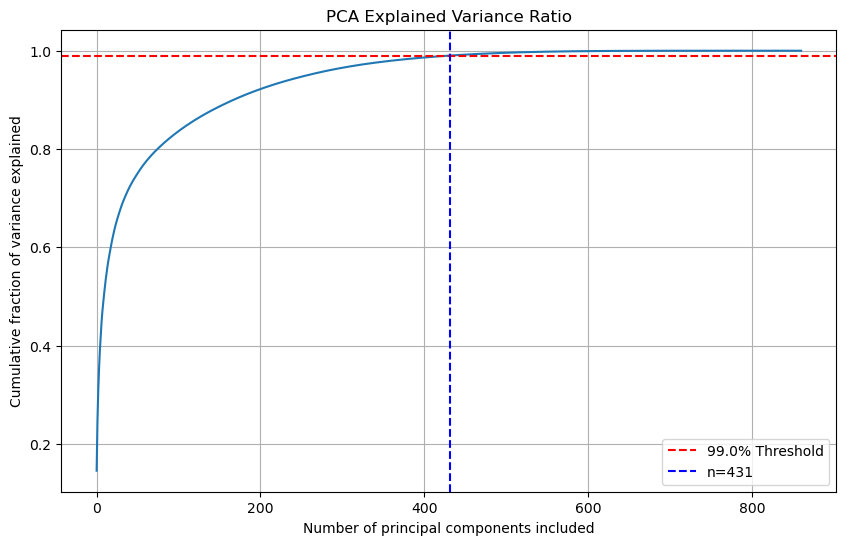

In [21]:
features, metadata = prepare_alignment_data(
    metadata, features, BATCH_COLS, PERTURBATION_NAME_COL, CONTROL_KEY, PERTURBATION_ID_COL
)

n_components, fig = pca_variance_plot(
    features, variance_threshold=0.99
)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Align and aggregate

- `VARIANCE_OR_NCOMP`: Variance or number of components to keep after PCA.
    Defaults to 128 (n_components). If between 0 and 1, select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified.
    If 1, a single component is kept, and if None, all components are kept.
    `0.99` is recommended method.
- `AGG_METHOD`: Method used to aggregate features. Can be `mean` or `median`. Usually `mean`.

In [22]:
VARIANCE_OR_NCOMP = 0.99
AGG_METHOD = "median"

/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/brieflow/workflow/lib/aggregate/align.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  embeddings[batch_ind] = np.matmul(
/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/brieflow/workflow/lib/aggregate/align.py:180: ComplexWarning: Casting complex values to real discards the imaginary part
  embeddings[batch_ind] = np.matmul(


Aligned feature distribtutions:


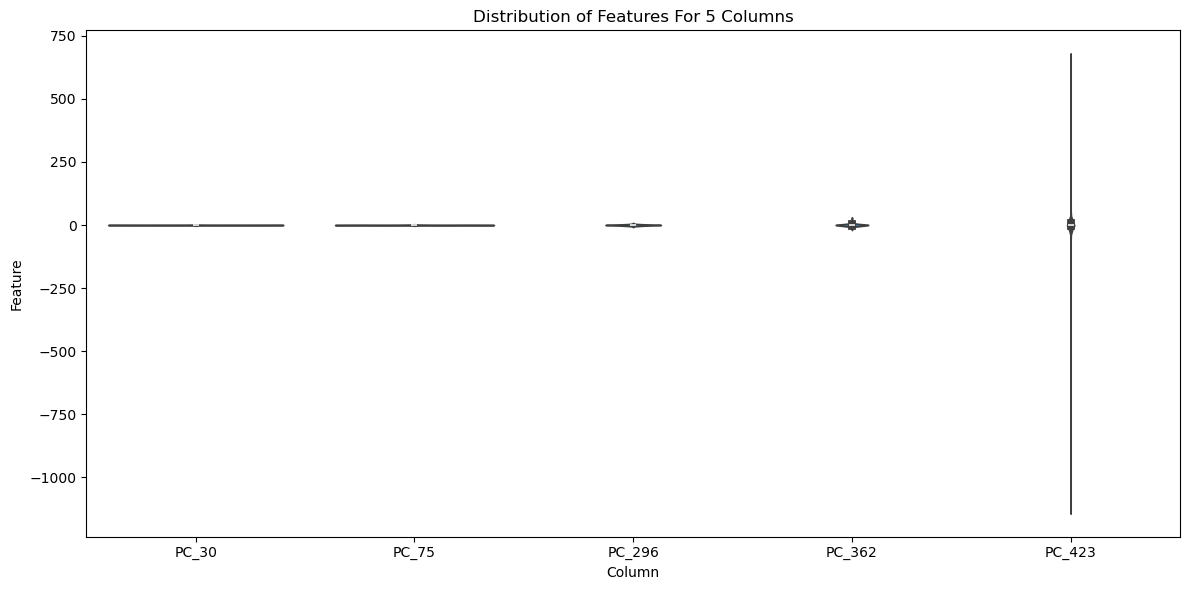

In [23]:
pca_embeddings = embed_by_pca(
    features, metadata, variance_or_ncomp=VARIANCE_OR_NCOMP, batch_col="batch_values"
)

tvn_normalized = tvn_on_controls(
    pca_embeddings, metadata, PERTURBATION_NAME_COL, CONTROL_KEY, "batch_values"
)

aggregated_embeddings, aggregated_metadata = aggregate(
    tvn_normalized, metadata, PERTURBATION_NAME_COL, AGG_METHOD
)

feature_columns = [f"PC_{i}" for i in range(tvn_normalized.shape[1])]

tvn_normalized_df = pd.DataFrame(
    tvn_normalized, index=metadata.index, columns=feature_columns
)
aligned_cell_data = pd.concat([metadata, tvn_normalized_df], axis=1)

aggregated_embeddings_df = pd.DataFrame(
    aggregated_embeddings, index=aggregated_metadata.index, columns=feature_columns
)
aggregated_cell_data = (
    pd.concat([aggregated_metadata, aggregated_embeddings_df], axis=1)
    .sort_values("cell_count", ascending=False)
    .reset_index(drop=True)
)

print("Aligned feature distribtutions:")
fig = plot_feature_distributions(aligned_cell_data, "PC_0", num_features=5)

## Add aggregate parameters to config file

In [24]:
# Add aggregate section
config["aggregate"] = {
    "metadata_cols_fp": METADATA_COLS_FP,
    "collapse_cols": COLLAPSE_COLS,
    "classifier_path": CLASSIFIER_PATH,
    "aggregate_combo_fp": AGGREGATE_COMBO_DF_FP,
    "filter_queries": FILTER_QUERIES,
    "perturbation_name_col": PERTURBATION_NAME_COL,
    "drop_cols_threshold": DROP_COLS_THRESHOLD,
    "drop_rows_threshold": DROP_ROWS_THRESHOLD,
    "impute": IMPUTE,
    "contamination": CONTAMINATION,
    "batch_cols": BATCH_COLS,
    "control_key": CONTROL_KEY,
    "perturbation_id_col": PERTURBATION_ID_COL,
    "variance_or_ncomp": VARIANCE_OR_NCOMP,
    "agg_method": AGG_METHOD,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)